# Exploring Dandiset 001276: Remote Targeting Electroporation and Cell Permeabilization

**Warning**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. The user should be cautious when interpreting the code or results. The primary purpose of this notebook is to help researchers get started with analyzing the dataset.

## Introduction

This notebook explores Dandiset 001276: "NG-CANCAN Remote Targeting Electroporation: Impact of Burst Number Variation on Permeabilization Distribution in Confluent Cell Monolayers". The dataset investigates the effects of varying burst numbers in the CANCAN (Canceling Pulses) protocol on cell permeabilization across confluent cell monolayers.

The experiments were conducted using a four-electrode array with an inter-electrode distance of 10.0 mm, focusing on optimizing the CANCAN protocol. The CANCAN protocol utilizes canceling pulses to minimize cell damage near the electrodes while targeting cells in the center of the electrode array. Each single pulse in the protocol had a duration of 600 ns. The protocol consisted of nine packets of pulses delivered at a frequency of 0.2 MHz and was repeated 1, 2, 4, or 6 times at a frequency of 1 Hz.

Cell monolayer integrity was assessed using Hoechst (DAPI) staining, while membrane permeability was evaluated using YoPro-1 (FITC).

## Importing Necessary Libraries

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile
import os
import re
import warnings

# Set up plotting style
sns.set_theme()

# Ignore warnings for cleaner notebook output
warnings.filterwarnings("ignore")

## Getting Dandiset Information

First, we'll connect to the DANDI API to get information about Dandiset 001276.

In [2]:
# Initialize DANDI API client
client = DandiAPIClient()
dandiset = client.get_dandiset("001276")

# Get Dandiset metadata using raw metadata to avoid validation errors
print(f"Dandiset ID: {dandiset.identifier}")
raw_metadata = dandiset.get_raw_metadata()
print(f"Dandiset Name: {raw_metadata.get('name', 'Not available')}")
print(f"Version: {dandiset.version_id}")

# Get description
description = raw_metadata.get('description', 'Not available')
print("\nDescription:")
print(description)

# Get citation information
citation = raw_metadata.get('citation', 'Not available')
print("\nCitation:")
print(citation)

Dandiset ID: 001276
Dandiset Name: NG-CANCAN Remote Targeting Electroporation: Impact of Burst Number Variation on Permeabilization Distribution in Confluent Cell Monolayers
Version: draft

Description:
Experiments were conducted using a four-electrode array with an inter-electrode distance of 10.0 mm. The study focused on optimizing the CANCAN protocol and investigating the effect of varying burst numbers on permeabilization distribution across confluent cell monolayers. The CANCAN protocols utilized canceling pulses to minimize cell damage near the electrodes while targeting cells in the center of the electrode array. Each single pulse in the protocol had a duration of 600 ns. The protocol consisted of nine packets of pulses delivered at a frequency of 0.2 MHz and was repeated 1, 2, 4, or 6 times at a frequency of 1 Hz. Cell monolayer integrity was assessed using Hoechst staining, while membrane permeability was evaluated using YoPro-1. This work was partially supported by NIH grant 

## Exploring the Dataset Structure

Let's examine what files are available in this Dandiset.

In [3]:
# Get list of all assets
assets = list(dandiset.get_assets())

# Print total count
print(f"Total number of assets: {len(assets)}")

# Create a pandas DataFrame for easier analysis
data = []
for asset in assets:
    path = asset.path
    parts = path.split('/')
    
    # Extract subject, date, and condition from the filename
    filename = parts[-1]
    match = re.match(r'sub-([^_]+)_.*', filename)
    subject_id = parts[0] if match else None
    
    # Extract if it's a different object within the same subject/condition
    obj_match = re.search(r'obj-([^_]+)', filename)
    obj_id = obj_match.group(1) if obj_match else None
    
    data.append({
        'path': path,
        'asset_id': asset.identifier,
        'subject_id': subject_id,
        'obj_id': obj_id,
        'size_mb': asset.size / (1024 * 1024)  # Convert to MB
    })

# Create DataFrame
df = pd.DataFrame(data)

# Extract condition information (A1, A2, B1, B2, etc.)
df['condition'] = df['subject_id'].str.extract(r'P\d+-\d++-([A-Z]\d)')

# Display first few assets
print("\nSample of assets:")
pd.set_option('display.max_colwidth', 40)  # Set column width for better display
df.head(10)

Total number of assets: 108

Sample of assets:


path  \
0  sub-P1-20240627-A2/sub-P1-20240627-A...   
1  sub-P1-20240627-A3/sub-P1-20240627-A...   
2  sub-P1-20240627-A2/sub-P1-20240627-A...   
3  sub-P1-20240627-A3/sub-P1-20240627-A...   
4  sub-P1-20240627-B1/sub-P1-20240627-B...   
5  sub-P1-20240627-B1/sub-P1-20240627-B...   
6  sub-P1-20240627-B2/sub-P1-20240627-B...   
7  sub-P1-20240627-B2/sub-P1-20240627-B...   
8  sub-P1-20240627-B3/sub-P1-20240627-B...   
9  sub-P1-20240627-B3/sub-P1-20240627-B...   

                               asset_id          subject_id   obj_id  \
0  d22476ad-fa18-4aa0-84bf-13fd0113a52c  sub-P1-20240627-A2   fniblx   
1  5a8061d9-3757-4a86-8542-2ae90133fdcd  sub-P1-20240627-A3  1h4rh2m   
2  95141d7a-82aa-4552-940a-1438a430a0d7  sub-P1-20240627-A2  1aoyzxh   
3  90ab1ffc-03ff-4193-8e47-9bbfbfd56bb5  sub-P1-20240627-A3   k9o87l   
4  e671bd0e-531d-4219-b38b-480d6179a7fc  sub-P1-20240627-B1  1qpzwid   
5  51916ccb-a1a1-4f64-b504-e6fbcb78d4dc  sub-P1-20240627-B1   4puzhd   
6  ce845c9b-eba3-43d2-aa82-5242b6a19515  sub-P1-20240627-B2  1nit1bi   
7  0cdd7366-3d77-499a-a72d-f434d985b216  sub-P1-20240627-B2   31iy1r   
8  e3b5448e-9e6f-45c2-9983-509346811fe0  sub-P1-20240627-B3  1p8hcsr   
9  b8ecbb72-d3a0-41b9-a81e-19719981c8ed  sub-P1-20240627-B3  1j97opj   

      size_mb condition  
0  356.114412        A2  
1  396.051540        A3  
2  449.242319        A2  
3  451.937449        A3  
4  451.891797        B1  
5  355.567163        B1  
6  461.322927        B2  
7  403.793153        B2  
8  380.530362        B3  
9  461.457496        B3

## Understanding the Dataset Structure

Let's analyze the distribution of files across different conditions and subjects.

File distribution by condition:
condition
A2    23
A3    20
B3    18
B1    16
B2    16
A1    15
Name: count, dtype: int64


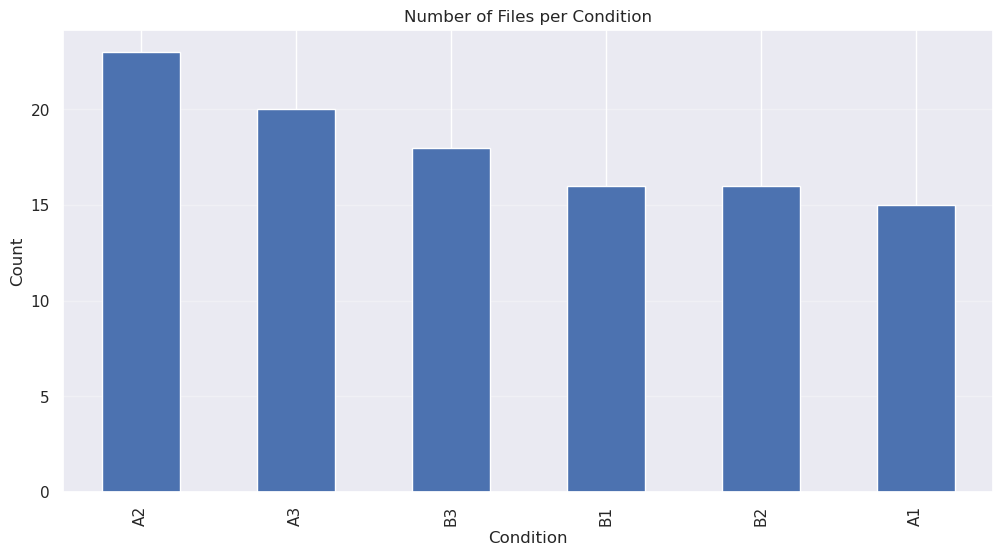

In [4]:
# Analyze file distribution by condition
print("File distribution by condition:")
condition_counts = df['condition'].value_counts()
print(condition_counts)

# Plot the distribution
plt.figure(figsize=(12, 6))
condition_counts.plot(kind='bar')
plt.title('Number of Files per Condition')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)

The conditions (A1, A2, A3, B1, B2, B3) likely correspond to different burst numbers in the CANCAN electroporation protocol:

- A1, A2, A3: These may represent Protocol A with 1, 2, and 4 bursts respectively
- B1, B2, B3: These may represent Protocol B with 1, 2, and 6 bursts respectively

Each condition has multiple files, corresponding to different imaging data from the same experimental conditions.

## Loading and Exploring an NWB File

Now, let's load a sample NWB file to understand its structure and content. We'll select one file from the assets.

In [5]:
# Select a sample file (first in the list)
sample_asset = assets[0]
print(f"Selected asset: {sample_asset.path}")
print(f"Asset ID: {sample_asset.identifier}")
print(f"Size: {sample_asset.size / (1024 * 1024):.2f} MB")

# Construct the URL for file download
url = f"https://api.dandiarchive.org/api/assets/{sample_asset.identifier}/download/"
print(f"Download URL: {url}")

Selected asset: sub-P1-20240627-A2/sub-P1-20240627-A2_obj-fniblx_image.nwb
Asset ID: d22476ad-fa18-4aa0-84bf-13fd0113a52c
Size: 356.11 MB
Download URL: https://api.dandiarchive.org/api/assets/d22476ad-fa18-4aa0-84bf-13fd0113a52c/download/


Now let's load the NWB file and explore its structure.

In [6]:
# Load the NWB file
def load_nwb_file(asset_id):
    url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
    file = remfile.File(url)
    f = h5py.File(file)
    io = pynwb.NWBHDF5IO(file=f)
    nwb = io.read()
    return nwb

# Load our sample file
nwb = load_nwb_file(sample_asset.identifier)

### Examining NWB File Metadata

Let's examine the metadata in this NWB file.

In [7]:
# Print basic metadata
print(f"Session ID: {nwb.session_id}")
print(f"Session Description: {nwb.session_description[:500]}...")  # Truncate if too long
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")
print(f"Lab: {nwb.lab}")

# Get subject information
print("\nSubject Information:")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Species: {nwb.subject.species}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Description: {nwb.subject.description[:500]}...")  # Truncate if too long

Session ID: single_time_point
Session Description: Acquisition Description (Subject-Specific): Subject ID: P1_20240627_A2, Fluorescent Channel: FITC, Phase: post (where 'pre' indicates imaging prior to exposure and 'post' indicates imaging of the same well after exposure).  CanCan protocol (with canceling pulses),011: Protocol consisted of 9 packets of pulses delivered at 0.2MHz frequency, protocol repeated 2 times at 1Hz frequency. General Protocol Description (Subject-Independent): Experiments were conducted using a four-electrode stainless st...
Identifier: 46d0cf2b-609a-440c-852b-f7d8139e9466
Session Start Time: 2024-12-12 14:44:22.516529-05:00
Institution: Old Dominion University
Lab: Pakhomov Lab

Subject Information:
Subject ID: P1_20240627_A2
Species: http://purl.obolibrary.org/obo/NCBITaxon_10090
Age: P1D
Sex: U
Description: Acquisition Description (Subject-Specific): Subject ID: P1_20240627_A2, Fluorescent Channel: FITC, Phase: post (where 'pre' indicates imaging prior to exp

### Extracting Fluorescence Channel Information

From the session description, we can extract information about the fluorescence channel used in this file.

In [8]:
# Extract fluorescence channel information
description = nwb.session_description
channel_match = re.search(r'Fluorescent Channel:\s*(\w+)', description)
channel = channel_match.group(1) if channel_match else "Unknown"
print(f"Fluorescence Channel: {channel}")

# Extract subject ID and condition
subject_id = nwb.subject.subject_id
condition_match = re.search(r'P\d+_\d+_([A-Z]\d)', subject_id)
condition = condition_match.group(1) if condition_match else "Unknown"
print(f"Condition: {condition}")

Fluorescence Channel: FITC
Condition: A2


## Examining Data Content

The NWB files in this dataset contain imaging data. Let's explore the data structures within the NWB file.

In [9]:
# Check what's available in acquisition
print("Acquisition Data Types:")
for key in nwb.acquisition.keys():
    data_type = type(nwb.acquisition[key]).__name__
    print(f"  - {key}: {data_type}")
    
# Check imaging data if available
if "SingleTimePointImaging" in nwb.acquisition:
    img_data = nwb.acquisition["SingleTimePointImaging"]
    print("\nImaging Data Information:")
    print(f"Dimensions: {img_data.dimension[:]}")
    print(f"Data Shape: {img_data.data.shape}")
    print(f"Data Type: {img_data.data.dtype}")
    print(f"Unit: {img_data.unit}")
    print(f"Resolution: {img_data.resolution}")
    print(f"Description: {img_data.description[:200]}...")  # Truncate if too long

Acquisition Data Types:
  - SingleTimePointImaging: ImageSeries

Imaging Data Information:
Dimensions: [19190 19190]
Data Shape: (1, 19190, 19190)
Data Type: uint16
Unit: n.a.
Resolution: 0.1
Description: Acquisition Description (Subject-Specific): Subject ID: P1_20240627_A2, Fluorescent Channel: FITC, Phase: post (where 'pre' indicates imaging prior to exposure and 'post' indicates imaging of the same...


## Visualizing Image Data

Let's load and visualize a sample of the image data. Since the images are large (19190 x 19190), we'll extract a smaller central region for efficient visualization.

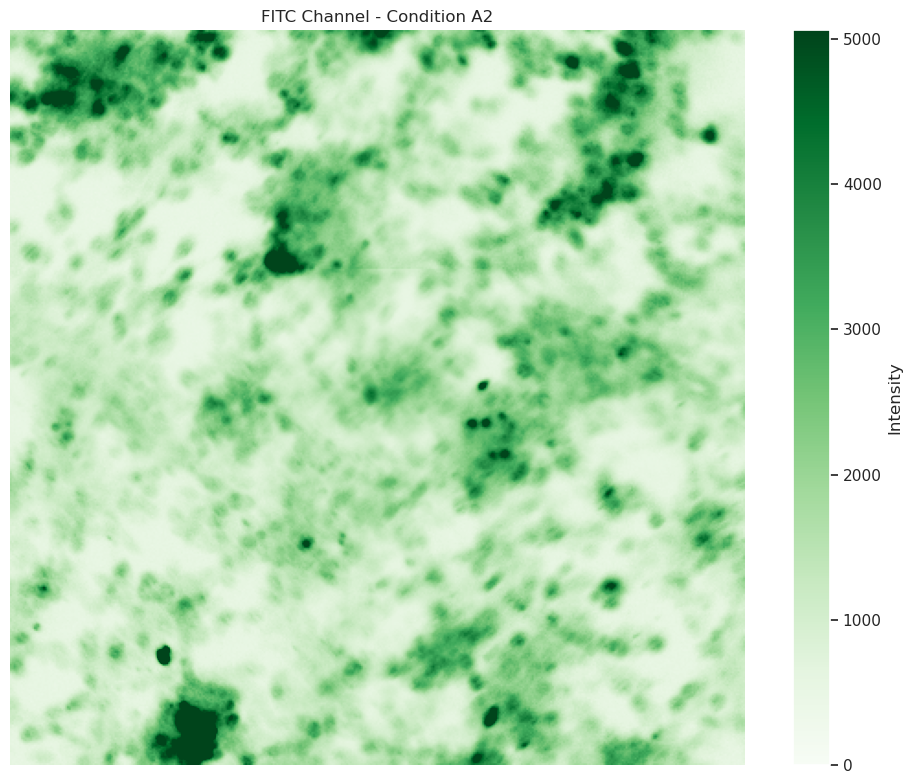

In [10]:
def visualize_sample_image(nwb_file, title=None):
    # Get image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    
    # Get the center coordinates
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    
    # Define the size of the region to extract
    margin = 200
    
    # Extract a central region
    central_region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Determine colormap based on channel
    description = nwb_file.session_description
    channel_match = re.search(r'Fluorescent Channel:\s*(\w+)', description)
    channel = channel_match.group(1) if channel_match else "Unknown"
    
    cmap = 'Blues' if channel == 'DAPI' else 'Greens'
    
    # Plot with a reasonable vmax (99th percentile for better contrast)
    vmax = np.percentile(central_region, 99)
    plt.imshow(central_region, cmap=cmap, vmin=0, vmax=vmax)
    
    # Add colorbar and labels
    plt.colorbar(label='Intensity')
    if title:
        plt.title(title)
    else:
        plt.title(f'{channel} Channel Image')
    
    plt.axis('off')
    plt.tight_layout()

# Visualize our sample
visualize_sample_image(nwb, f"{channel} Channel - Condition {condition}")

## Exploring Multiple Files with Different Conditions

Let's select and compare images from different conditions. We'll select one sample from each condition to understand how the CANCAN protocol with different burst numbers affects cell permeabilization.

In [11]:
# Define a sample of assets from different conditions
condition_samples = {}
processed_conditions = set()

# Loop through all assets to find one from each condition
for asset in assets[:50]:  # Limit to first 50 to avoid long processing
    path = asset.path
    # Extract condition
    condition_match = re.search(r'P\d+-\d++-([A-Z]\d)', path)
    if condition_match:
        condition = condition_match.group(1)
        if condition not in processed_conditions:
            condition_samples[condition] = {
                'id': asset.identifier,
                'path': path
            }
            processed_conditions.add(condition)
    
    # If we have 6 conditions (A1, A2, A3, B1, B2, B3), we're done
    if len(processed_conditions) >= 6:
        break

# Print selected samples
print("Selected samples from different conditions:")
for condition, sample in condition_samples.items():
    print(f"Condition {condition}: {sample['path']}")

Selected samples from different conditions:
Condition A2: sub-P1-20240627-A2/sub-P1-20240627-A2_obj-fniblx_image.nwb
Condition A3: sub-P1-20240627-A3/sub-P1-20240627-A3_obj-1h4rh2m_image.nwb
Condition B1: sub-P1-20240627-B1/sub-P1-20240627-B1_obj-1qpzwid_image.nwb
Condition B2: sub-P1-20240627-B2/sub-P1-20240627-B2_obj-1nit1bi_image.nwb
Condition B3: sub-P1-20240627-B3/sub-P1-20240627-B3_obj-1p8hcsr_image.nwb
Condition A1: sub-P1-20240702-A1/sub-P1-20240702-A1_image.nwb


Now let's load and analyze data from these different conditions.

In [12]:
# Load all sample NWB files
nwb_samples = {}
channel_by_condition = {}
for condition, sample in condition_samples.items():
    try:
        nwb_file = load_nwb_file(sample['id'])
        nwb_samples[condition] = nwb_file
        
        # Extract channel information
        description = nwb_file.session_description
        channel_match = re.search(r'Fluorescent Channel:\s*(\w+)', description)
        channel = channel_match.group(1) if channel_match else "Unknown"
        channel_by_condition[condition] = channel
        
        print(f"Loaded Condition {condition}: {channel} Channel")
    except Exception as e:
        print(f"Error loading condition {condition}: {str(e)}")

Loaded Condition A2: FITC Channel


Loaded Condition A3: FITC Channel


Loaded Condition B1: DAPI Channel


Loaded Condition B2: DAPI Channel


Loaded Condition B3: FITC Channel


Loaded Condition A1: FITC Channel


Let's visualize a sample image from each condition.

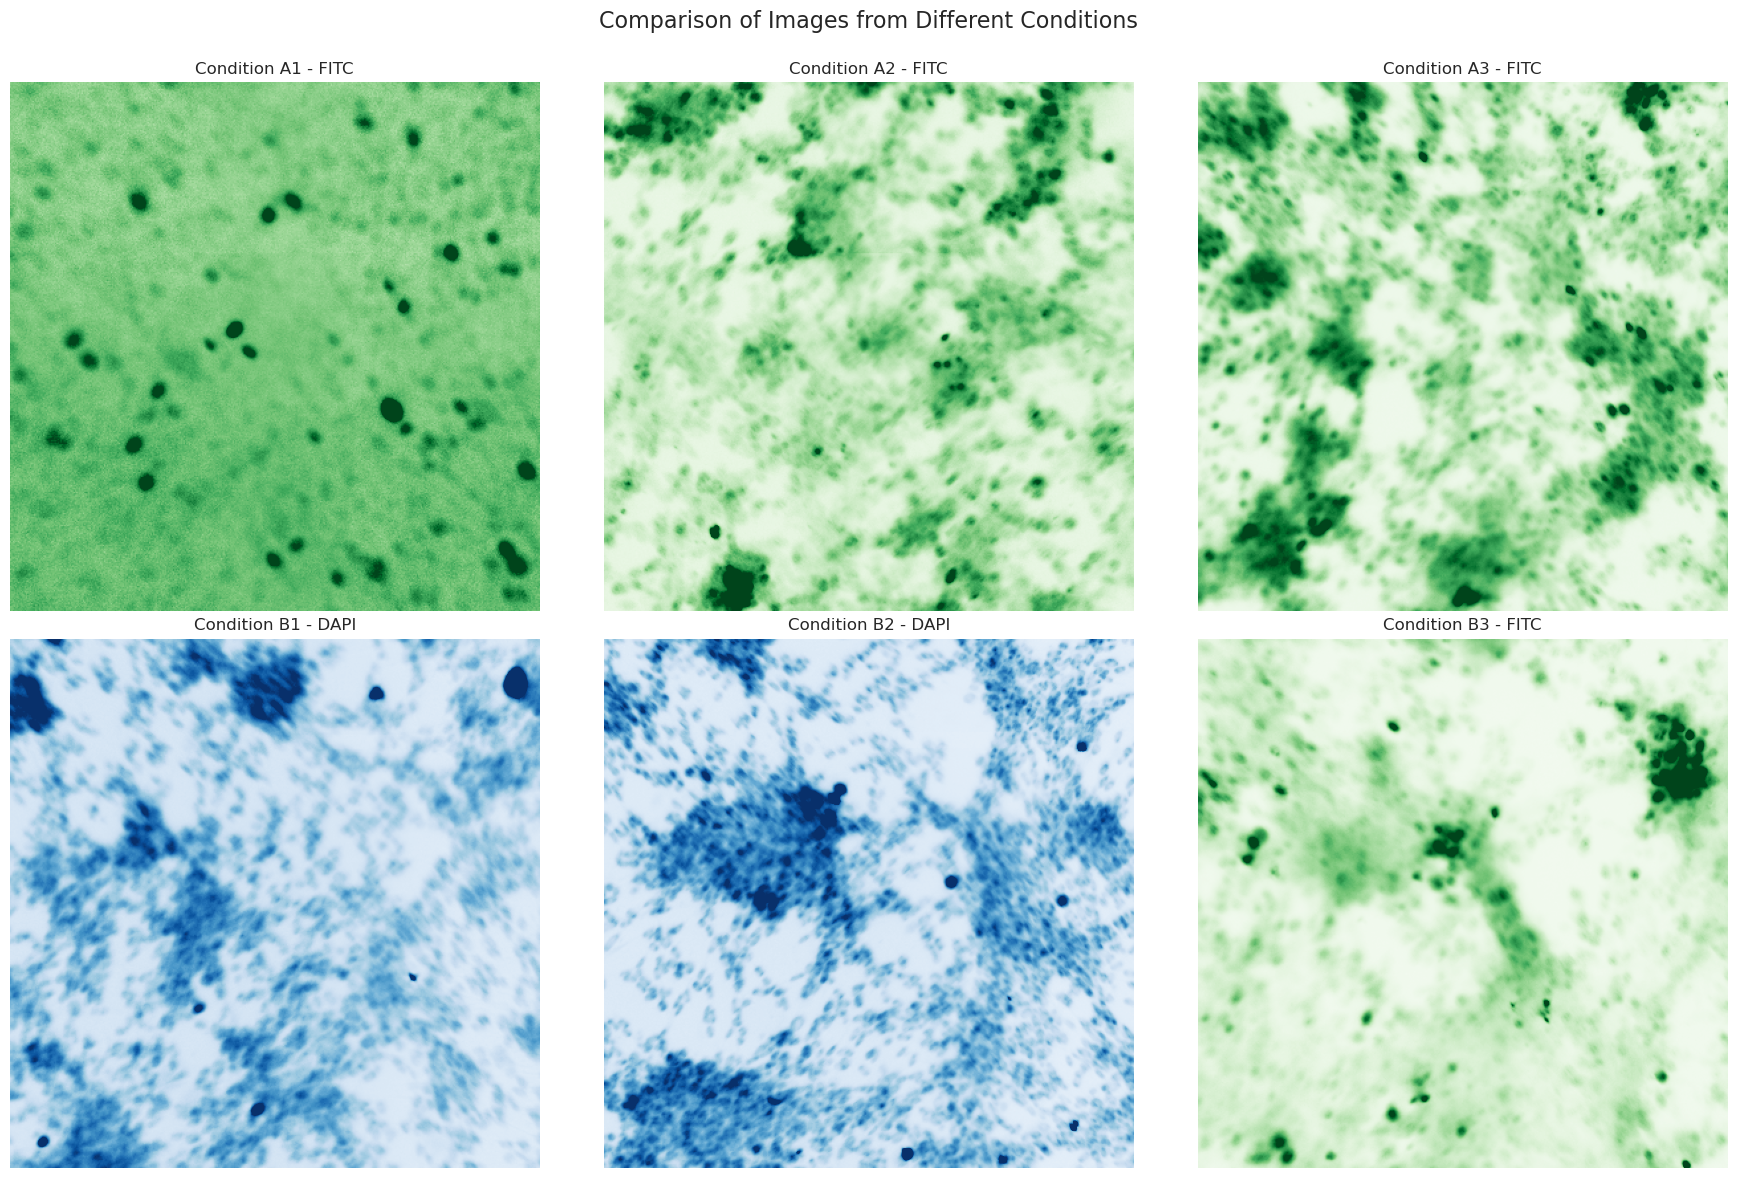

In [13]:
if nwb_samples:
    # Create a multi-panel figure
    fig = plt.figure(figsize=(18, 12))
    
    # Sort conditions
    sorted_conditions = sorted(nwb_samples.keys())
    
    for i, condition in enumerate(sorted_conditions):
        nwb_file = nwb_samples[condition]
        channel = channel_by_condition[condition]
        
        # Create subplot
        plt.subplot(2, 3, i+1)
        
        # Get image data
        img_data = nwb_file.acquisition["SingleTimePointImaging"].data
        dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
        
        # Get the center coordinates
        center_x = dimensions[0] // 2
        center_y = dimensions[1] // 2
        
        # Define the size of the region to extract
        margin = 200
        
        # Extract a central region
        central_region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
        
        # Determine colormap based on channel
        cmap = 'Blues' if channel == 'DAPI' else 'Greens'
        
        # Plot with a reasonable vmax (99th percentile for better contrast)
        vmax = np.percentile(central_region, 99)
        plt.imshow(central_region, cmap=cmap, vmin=0, vmax=vmax)
        
        # Add title and turn off axis
        plt.title(f'Condition {condition} - {channel}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle('Comparison of Images from Different Conditions', fontsize=16)
    plt.subplots_adjust(top=0.92)

## Analyzing Image Intensity Across Conditions

Let's analyze and compare the intensity distributions across different conditions to understand how the CANCAN protocol with different burst numbers affects cell permeabilization.

In [14]:
# Function to extract image statistics
def get_image_stats(nwb_file):
    # Get image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    
    # Get the center coordinates
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    
    # Define a larger region for better statistics (500x500)
    margin = 250
    
    # Extract region
    region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Calculate statistics
    min_val = np.min(region)
    max_val = np.max(region)
    mean_val = np.mean(region)
    median_val = np.median(region)
    std_val = np.std(region)
    
    # Calculate percentiles
    p25 = np.percentile(region, 25)
    p50 = np.percentile(region, 50)
    p75 = np.percentile(region, 75)
    p90 = np.percentile(region, 90)
    p99 = np.percentile(region, 99)
    
    return {
        'min': min_val,
        'max': max_val,
        'mean': mean_val,
        'median': median_val,
        'std': std_val,
        'p25': p25,
        'p50': p50,
        'p75': p75,
        'p90': p90,
        'p99': p99
    }

# Extract statistics for each condition
stats_by_condition = {}
for condition, nwb_file in nwb_samples.items():
    channel = channel_by_condition[condition]
    stats = get_image_stats(nwb_file)
    stats['channel'] = channel
    stats_by_condition[condition] = stats

# Convert to DataFrame
stats_df = pd.DataFrame.from_dict(stats_by_condition, orient='index')
stats_df.index.name = 'condition'
stats_df.reset_index(inplace=True)

# Display statistics
print(stats_df[['condition', 'channel', 'mean', 'median', 'p90']])

  condition channel         mean  median      p90
0        A2    FITC  1596.228660  1343.0   2812.0
1        A3    FITC  3739.515256  3192.0   7210.0
2        B1    DAPI  5218.149556  4569.0   8750.0
3        B2    DAPI  5835.820936  4978.0  10893.0
4        B3    FITC  2939.795816  2452.0   5243.1
5        A1    FITC   582.351904   563.0    680.0


Now let's visualize these statistics to see trends across conditions.

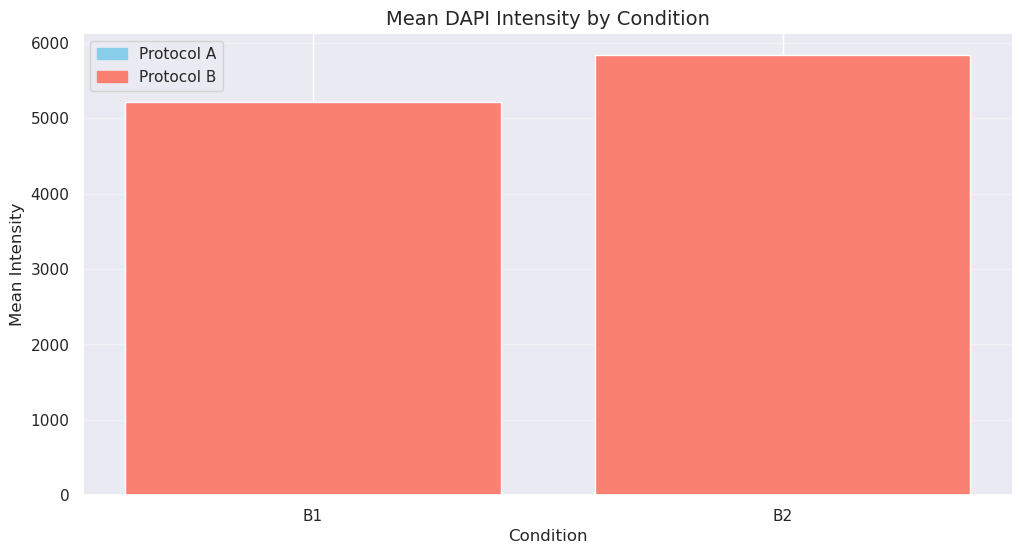

In [15]:
# Map conditions to presumed burst numbers based on the dataset description
burst_mapping = {
    'A1': 1,  # Assuming A1 = 1 burst
    'A2': 2,  # Assuming A2 = 2 bursts
    'A3': 4,  # Assuming A3 = 4 bursts
    'B1': 1,  # Assuming B1 = 1 burst (different protocol)
    'B2': 2,  # Assuming B2 = 2 bursts (different protocol)
    'B3': 6   # Assuming B3 = 6 bursts
}

# Add burst number and protocol type to the stats DataFrame
stats_df['burst_number'] = stats_df['condition'].map(burst_mapping)
stats_df['protocol_type'] = stats_df['condition'].str[0]

# Filter for DAPI channel (if available)
dapi_stats = stats_df[stats_df['channel'] == 'DAPI']

# Plot mean intensity by condition
if not dapi_stats.empty:
    plt.figure(figsize=(12, 6))
    
    # Sort conditions
    dapi_stats = dapi_stats.sort_values(by='condition')
    
    # Create bar plot
    bars = plt.bar(dapi_stats['condition'], dapi_stats['mean'], 
            color=dapi_stats['protocol_type'].map({'A': 'skyblue', 'B': 'salmon'}))
    
    # Add condition and protocol type labels
    plt.title('Mean DAPI Intensity by Condition', fontsize=14)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Mean Intensity', fontsize=12)
    
    # Add protocol type legend
    plt.legend(handles=[
        plt.Rectangle((0,0),1,1, color='skyblue', label='Protocol A'),
        plt.Rectangle((0,0),1,1, color='salmon', label='Protocol B')
    ])
    
    plt.grid(axis='y', alpha=0.3)

Let's also visualize the relationship between burst number and intensity.

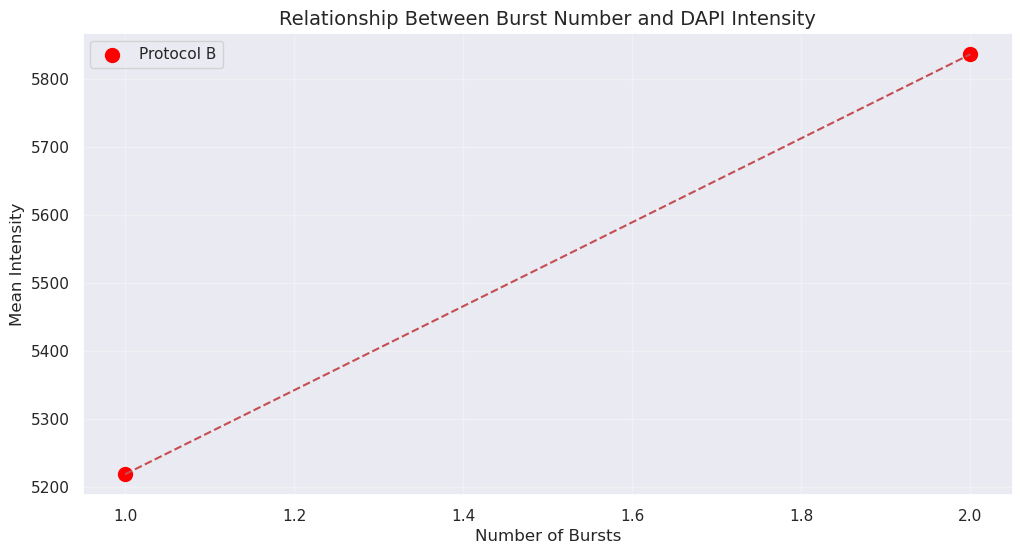

In [16]:
if not dapi_stats.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot for Protocol A
    protocol_a = dapi_stats[dapi_stats['protocol_type'] == 'A']
    if not protocol_a.empty:
        plt.scatter(protocol_a['burst_number'], protocol_a['mean'], 
                    color='blue', s=100, label='Protocol A')
        
        # Add linear trend line if we have enough points
        if len(protocol_a) > 1:
            z = np.polyfit(protocol_a['burst_number'], protocol_a['mean'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(protocol_a['burst_number'].min(), protocol_a['burst_number'].max(), 100)
            plt.plot(x_trend, p(x_trend), 'b--')
    
    # Plot for Protocol B
    protocol_b = dapi_stats[dapi_stats['protocol_type'] == 'B']
    if not protocol_b.empty:
        plt.scatter(protocol_b['burst_number'], protocol_b['mean'], 
                    color='red', s=100, label='Protocol B')
        
        # Add linear trend line if we have enough points
        if len(protocol_b) > 1:
            z = np.polyfit(protocol_b['burst_number'], protocol_b['mean'], 1)
            p = np.poly1d(z)
            x_trend = np.linspace(protocol_b['burst_number'].min(), protocol_b['burst_number'].max(), 100)
            plt.plot(x_trend, p(x_trend), 'r--')
    
    plt.title('Relationship Between Burst Number and DAPI Intensity', fontsize=14)
    plt.xlabel('Number of Bursts', fontsize=12)
    plt.ylabel('Mean Intensity', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()

## Intensity Histograms

Let's examine the pixel intensity distribution for images from different conditions.

In [17]:
def plot_intensity_histogram(nwb_file, title=None):
    # Get image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    
    # Get the center coordinates
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    
    # Define the size of the region to extract (500x500)
    margin = 250
    
    # Extract a central region
    region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Create histogram
    plt.figure(figsize=(12, 6))
    
    # Extract channel information for title
    description = nwb_file.session_description
    channel_match = re.search(r'Fluorescent Channel:\s*(\w+)', description)
    channel = channel_match.group(1) if channel_match else "Unknown"
    
    # Plot histogram
    plt.hist(region.flatten(), bins=100, alpha=0.7, 
             color='blue' if channel == 'DAPI' else 'green')
    
    # Add title and labels
    if title:
        plt.title(title)
    else:
        plt.title(f'Intensity Histogram - {channel} Channel')
        
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

Let's plot intensity histograms for different conditions to compare them.

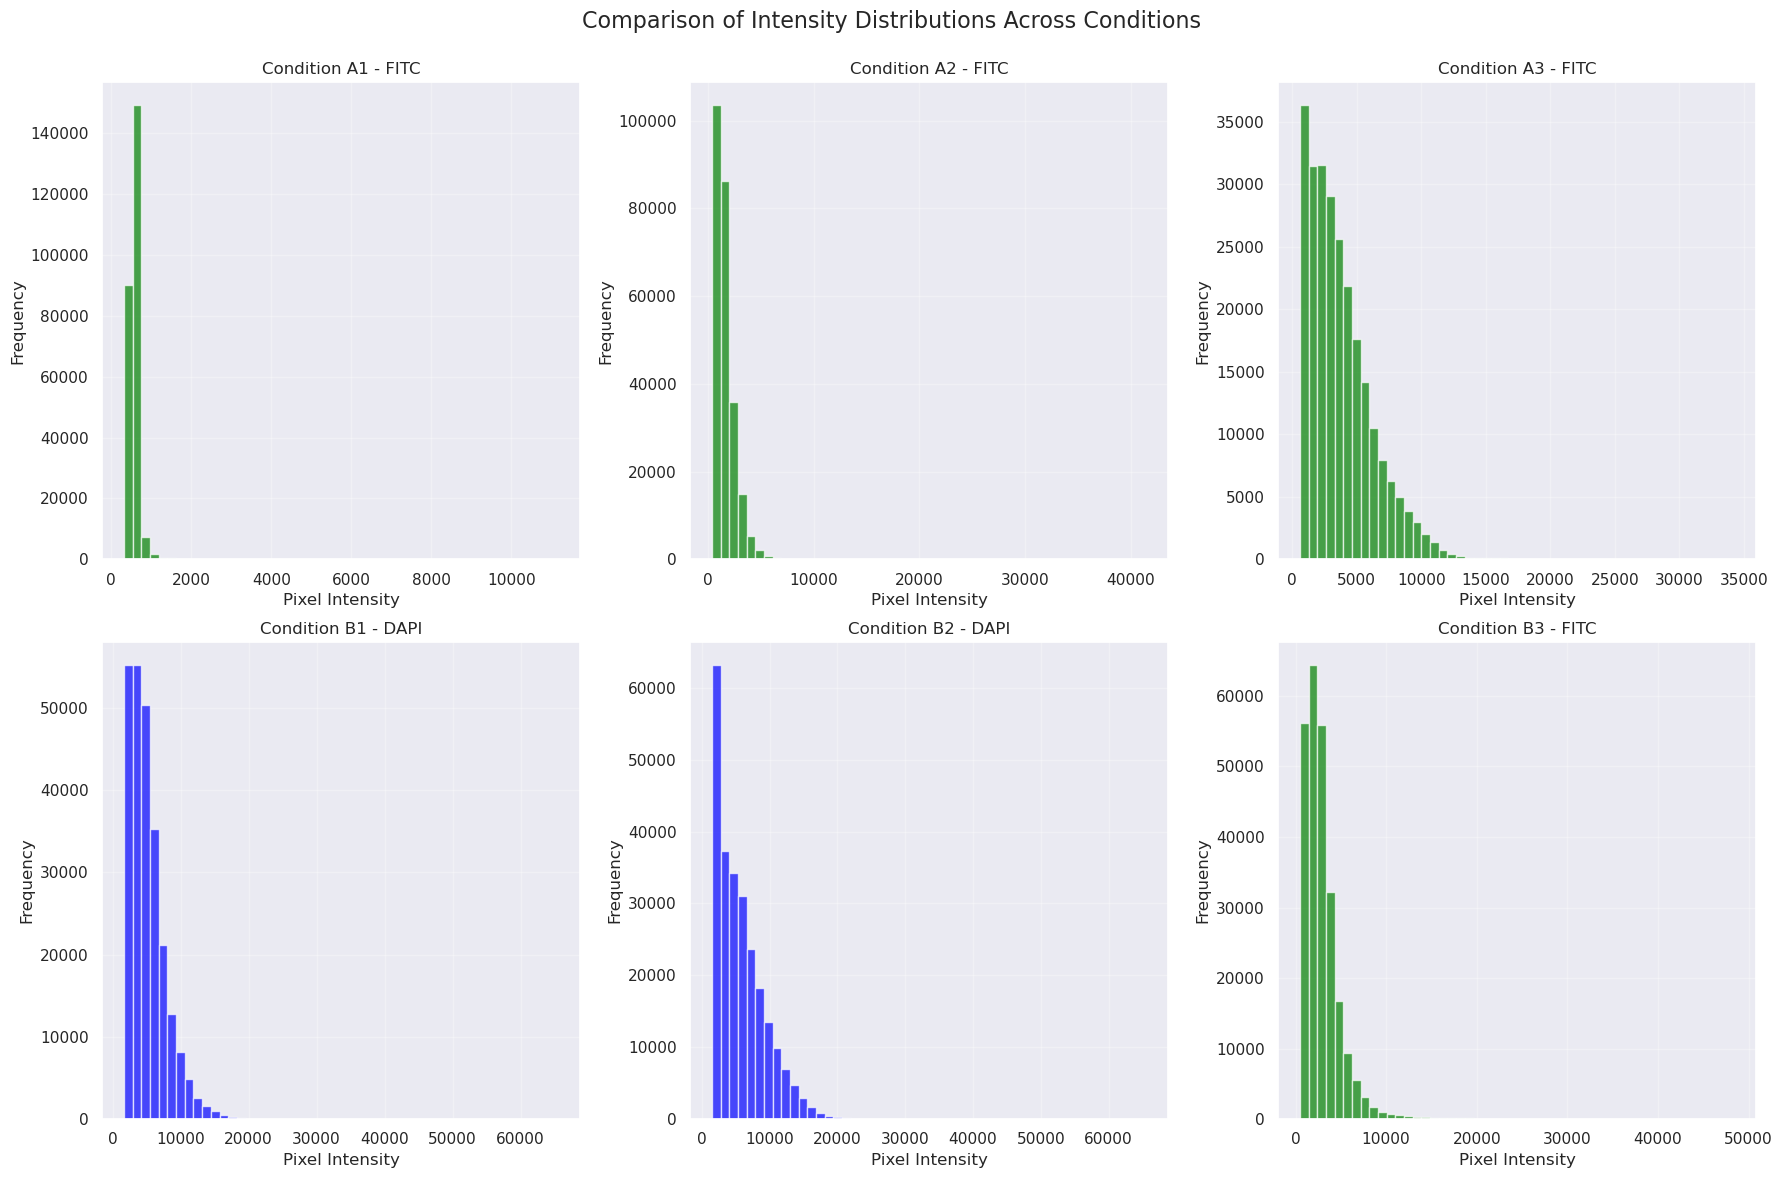

In [18]:
if nwb_samples:
    # Select conditions for comparison
    conditions_to_compare = sorted(nwb_samples.keys())[:6]  # Up to 6 conditions
    
    # Create a multi-panel figure
    fig = plt.figure(figsize=(18, 12))
    
    for i, condition in enumerate(conditions_to_compare):
        nwb_file = nwb_samples[condition]
        channel = channel_by_condition[condition]
        
        # Create subplot
        plt.subplot(2, 3, i+1)
        
        # Get image data
        img_data = nwb_file.acquisition["SingleTimePointImaging"].data
        dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
        
        # Get the center coordinates
        center_x = dimensions[0] // 2
        center_y = dimensions[1] // 2
        
        # Define the size of the region to extract
        margin = 250
        
        # Extract a central region
        region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
        
        # Determine color based on channel
        color = 'blue' if channel == 'DAPI' else 'green'
        
        # Plot histogram
        plt.hist(region.flatten(), bins=50, alpha=0.7, color=color)
        
        # Add title and labels
        plt.title(f'Condition {condition} - {channel}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Comparison of Intensity Distributions Across Conditions', fontsize=16)
    plt.subplots_adjust(top=0.92)

## Analyzing Cell Distribution Patterns

Let's perform a more advanced analysis to detect and quantify cells or nuclei in the images. We'll use a simple thresholding approach for this demonstration.

In [19]:
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops

def detect_and_count_cells(img_data, threshold_percentile=90):
    """
    Detect and count cells or nuclei in an image using thresholding.
    
    Parameters:
    -----------
    img_data : ndarray
        Image data
    threshold_percentile : int
        Percentile value for thresholding (default: 90)
    
    Returns:
    --------
    count : int
        Number of detected cells/nuclei
    labeled_img : ndarray
        Labeled image with each cell/nucleus assigned a unique integer
    """
    # Calculate threshold as percentile of non-zero values
    threshold = np.percentile(img_data[img_data > 0], threshold_percentile)
    
    # Create binary mask
    binary = img_data > threshold
    
    # Label connected components
    labeled, num_features = ndimage.label(binary)
    
    return num_features, labeled

def analyze_cell_distribution(nwb_file, margin=250):
    """Analyze cell distribution in an NWB file's image data."""
    # Get image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    
    # Get the center coordinates
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    
    # Extract a central region
    region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Detect and count cells
    cell_count, labeled_img = detect_and_count_cells(region)
    
    # Get region properties
    regions = regionprops(labeled_img, region)
    
    # Extract mean intensity of each cell/nucleus
    intensities = [region.mean_intensity for region in regions]
    
    return {
        'cell_count': cell_count,
        'mean_intensities': intensities,
        'labeled_img': labeled_img
    }

Let's apply this analysis to our sample images and visualize the results.

In [20]:
# Analyze cell distribution for each condition
cell_analysis = {}
for condition, nwb_file in nwb_samples.items():
    try:
        analysis = analyze_cell_distribution(nwb_file)
        cell_analysis[condition] = analysis
        print(f"Condition {condition}: Detected {analysis['cell_count']} cells/nuclei")
    except Exception as e:
        print(f"Error analyzing condition {condition}: {str(e)}")

Condition A2: Detected 351 cells/nuclei
Condition A3: Detected 281 cells/nuclei
Condition B1: Detected 275 cells/nuclei
Condition B2: Detected 556 cells/nuclei
Condition B3: Detected 248 cells/nuclei
Condition A1: Detected 3703 cells/nuclei


Let's visualize the detected cells/nuclei for one of the conditions.

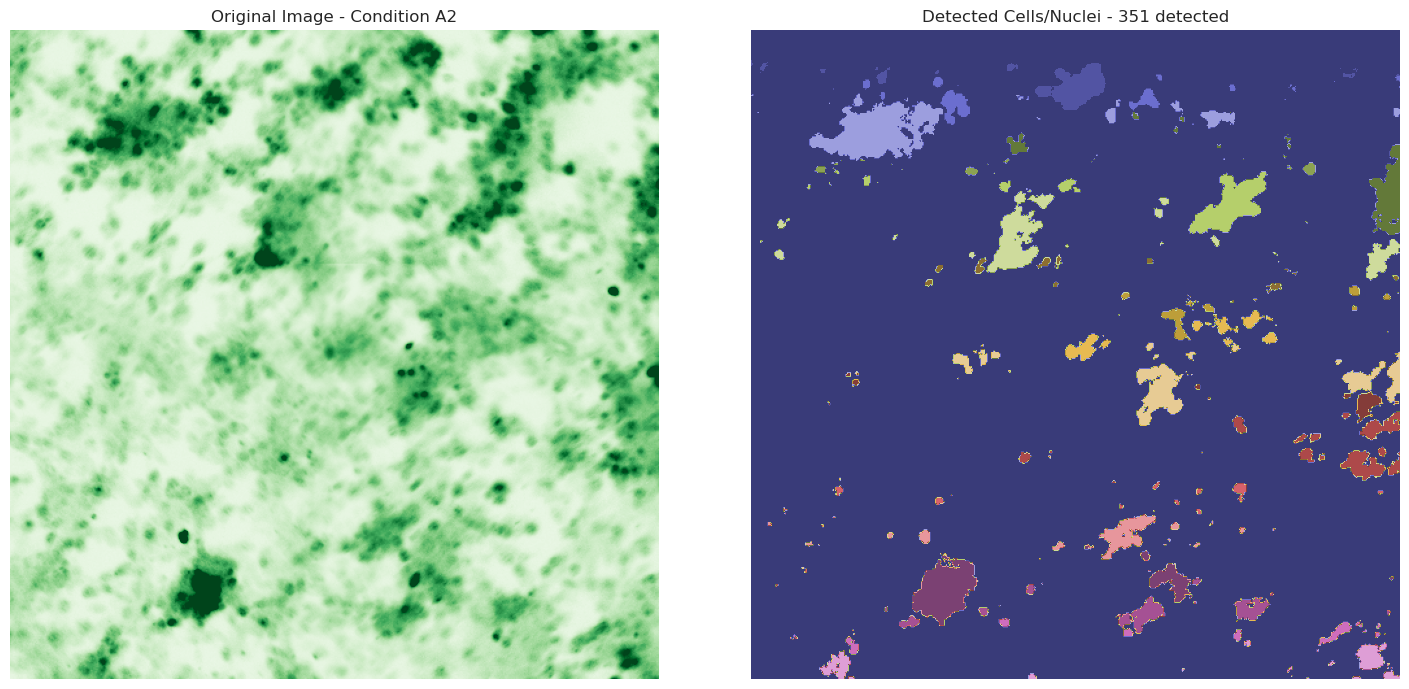

In [21]:
if cell_analysis:
    # Choose the first condition for visualization
    condition = list(cell_analysis.keys())[0]
    nwb_file = nwb_samples[condition]
    channel = channel_by_condition[condition]
    analysis = cell_analysis[condition]
    
    # Get original image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    margin = 250
    region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot original image
    vmax = np.percentile(region, 99)
    cmap = 'Blues' if channel == 'DAPI' else 'Greens'
    axes[0].imshow(region, cmap=cmap, vmin=0, vmax=vmax)
    axes[0].set_title(f'Original Image - Condition {condition}')
    axes[0].axis('off')
    
    # Plot labeled image
    axes[1].imshow(analysis['labeled_img'], cmap='tab20b')
    axes[1].set_title(f'Detected Cells/Nuclei - {analysis["cell_count"]} detected')
    axes[1].axis('off')
    
    plt.tight_layout()

## Comparing Cell Counts and Intensities Across Conditions

Let's compare the number of detected cells and their intensity distributions across different conditions.

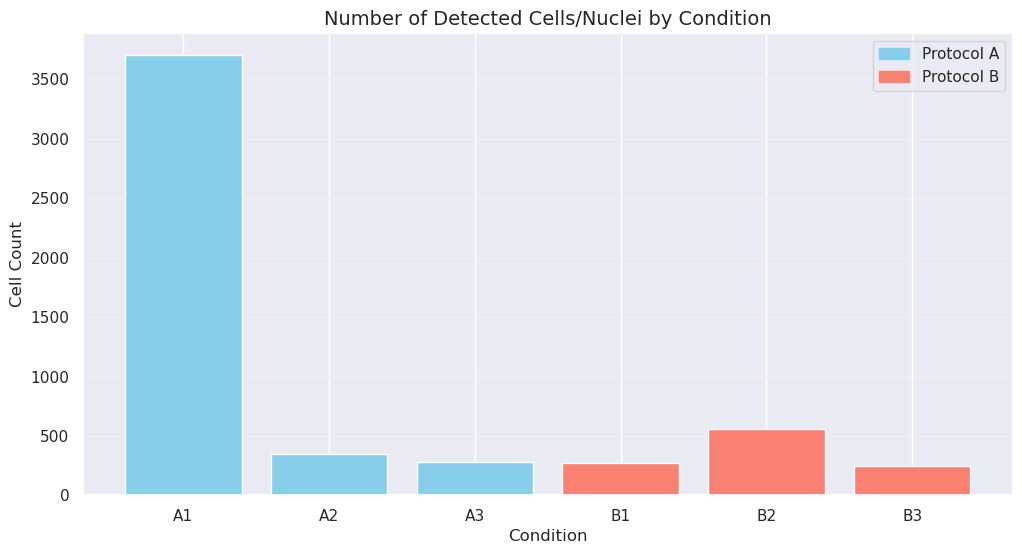

In [22]:
if cell_analysis:
    # Convert cell count data to DataFrame
    cell_counts = {cond: analysis['cell_count'] for cond, analysis in cell_analysis.items()}
    cell_count_df = pd.DataFrame.from_dict(cell_counts, orient='index', columns=['cell_count'])
    cell_count_df.index.name = 'condition'
    cell_count_df.reset_index(inplace=True)
    
    # Add condition information
    cell_count_df['protocol_type'] = cell_count_df['condition'].str[0]
    
    # Sort by condition
    cell_count_df = cell_count_df.sort_values(by='condition')
    
    # Plot cell counts
    plt.figure(figsize=(12, 6))
    
    # Create bar plot
    bars = plt.bar(cell_count_df['condition'], cell_count_df['cell_count'], 
                   color=cell_count_df['protocol_type'].map({'A': 'skyblue', 'B': 'salmon'}))
    
    # Add labels
    plt.title('Number of Detected Cells/Nuclei by Condition', fontsize=14)
    plt.xlabel('Condition', fontsize=12)
    plt.ylabel('Cell Count', fontsize=12)
    
    # Add protocol type legend
    plt.legend(handles=[
        plt.Rectangle((0,0),1,1, color='skyblue', label='Protocol A'),
        plt.Rectangle((0,0),1,1, color='salmon', label='Protocol B')
    ])
    
    plt.grid(axis='y', alpha=0.3)

Now let's look at the intensity distributions of the detected cells across different conditions.

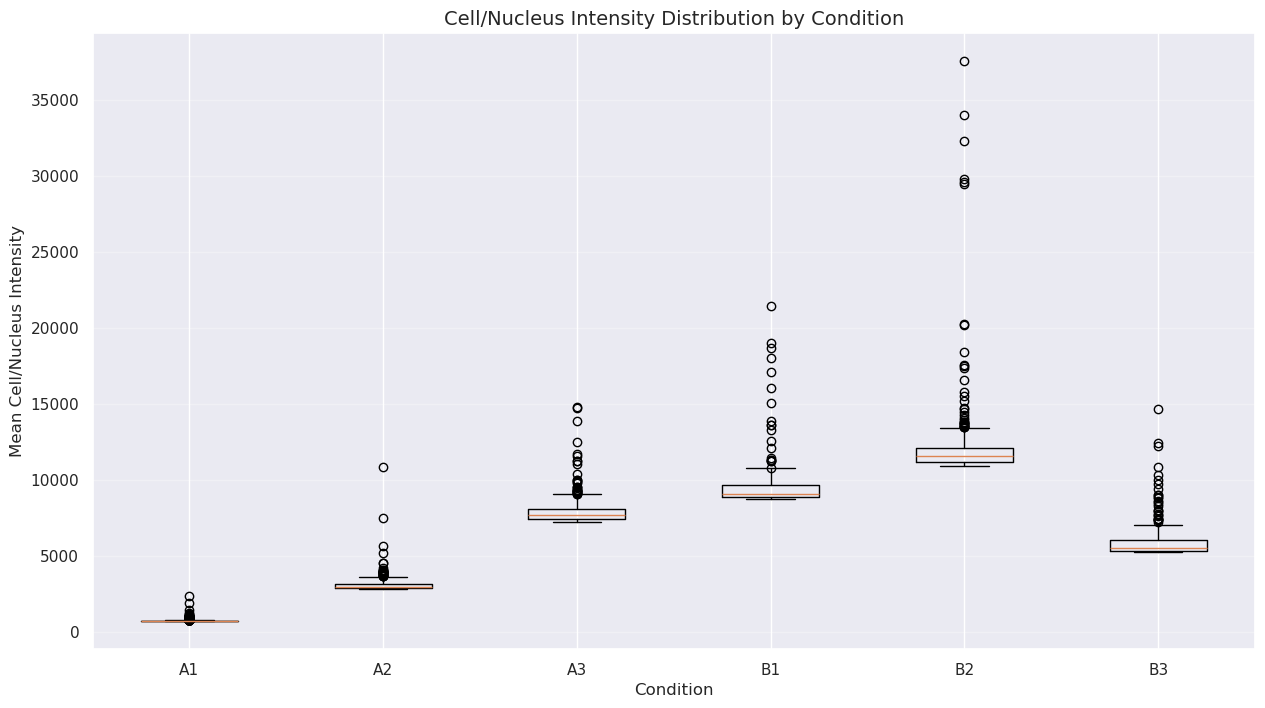

In [23]:
if cell_analysis:
    plt.figure(figsize=(15, 8))
    
    # Plot boxplots for each condition
    intensity_data = []
    labels = []
    
    for condition in sorted(cell_analysis.keys()):
        intensities = cell_analysis[condition]['mean_intensities']
        if intensities:  # Check if not empty
            intensity_data.append(intensities)
            labels.append(condition)
    
    # Create boxplot
    if intensity_data:
        plt.boxplot(intensity_data, labels=labels)
        plt.title('Cell/Nucleus Intensity Distribution by Condition', fontsize=14)
        plt.xlabel('Condition', fontsize=12)
        plt.ylabel('Mean Cell/Nucleus Intensity', fontsize=12)
        plt.grid(axis='y', alpha=0.3)

## Advanced Analysis: Spatial Distribution of Cell Permeability

For DAPI (Hoechst) and FITC (YoPro-1) images, we can assess the spatial distribution of cellular permeability by analyzing how intensities vary across different distances from the center of the electrode array.

In [24]:
def analyze_spatial_distribution(nwb_file, bins=5, margin=250):
    """
    Analyze spatial distribution of signal intensity from center to edge.
    
    Parameters:
    -----------
    nwb_file : pynwb.NWBFile
        NWB file object
    bins : int
        Number of concentric regions to analyze
    margin : int
        Size of square region to extract
    
    Returns:
    --------
    distances : array
        Mean distance from center for each bin
    intensities : array
        Mean intensity for each bin
    """
    # Get image data
    img_data = nwb_file.acquisition["SingleTimePointImaging"].data
    dimensions = nwb_file.acquisition["SingleTimePointImaging"].dimension[:]
    
    # Get the center coordinates
    center_x = dimensions[0] // 2
    center_y = dimensions[1] // 2
    
    # Extract a central region
    region = img_data[0, center_x-margin:center_x+margin, center_y-margin:center_y+margin]
    
    # Create a grid of coordinates
    y, x = np.ogrid[-margin:margin, -margin:margin]
    
    # Calculate distance from center for each pixel
    distances = np.sqrt(x*x + y*y)
    
    # Define distance bins
    max_distance = np.sqrt(2) * margin
    distance_bins = np.linspace(0, max_distance, bins+1)
    
    # Initialize arrays for results
    mean_distances = []
    mean_intensities = []
    
    # Calculate mean intensity for each radial bin
    for i in range(bins):
        # Create mask for this radial bin
        mask = (distances >= distance_bins[i]) & (distances < distance_bins[i+1])
        
        # Calculate mean distance and intensity for this bin
        mean_distance = np.mean(distances[mask])
        mean_intensity = np.mean(region[mask])
        
        mean_distances.append(mean_distance)
        mean_intensities.append(mean_intensity)
    
    return np.array(mean_distances), np.array(mean_intensities)

Let's apply this analysis to our sample images and visualize the results.

Analyzed spatial distribution for Condition A2
Analyzed spatial distribution for Condition A3
Analyzed spatial distribution for Condition B1
Analyzed spatial distribution for Condition B2
Analyzed spatial distribution for Condition B3
Analyzed spatial distribution for Condition A1


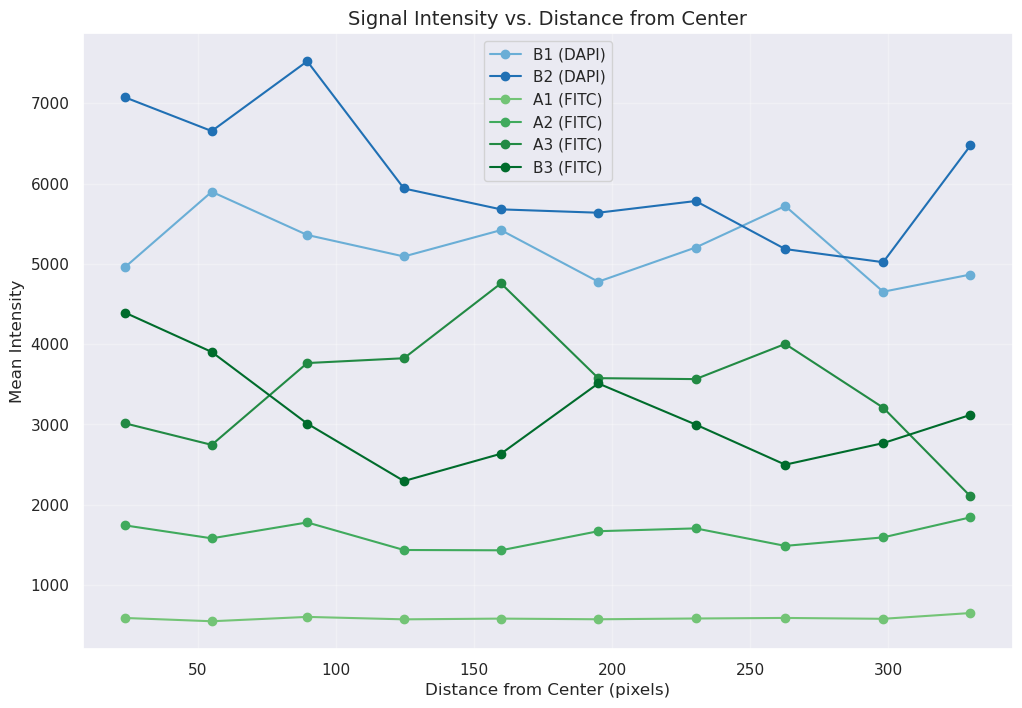

In [25]:
spatial_analysis = {}

for condition, nwb_file in nwb_samples.items():
    try:
        distances, intensities = analyze_spatial_distribution(nwb_file, bins=10)
        spatial_analysis[condition] = {
            'distances': distances,
            'intensities': intensities,
            'channel': channel_by_condition[condition]
        }
        print(f"Analyzed spatial distribution for Condition {condition}")
    except Exception as e:
        print(f"Error analyzing condition {condition}: {str(e)}")

# Plot the spatial distribution for all conditions
if spatial_analysis:
    plt.figure(figsize=(12, 8))
    
    # Group by channel type
    dapi_conditions = []
    fitc_conditions = []
    
    for condition, data in spatial_analysis.items():
        if data['channel'] == 'DAPI':
            dapi_conditions.append(condition)
        elif data['channel'] == 'FITC':
            fitc_conditions.append(condition)
    
    # Plot DAPI channels with blues
    for i, condition in enumerate(sorted(dapi_conditions)):
        data = spatial_analysis[condition]
        plt.plot(data['distances'], data['intensities'], 
                 'o-', color=plt.cm.Blues(0.5 + 0.5*i/len(dapi_conditions)),
                 label=f"{condition} ({data['channel']})")
    
    # Plot FITC channels with greens
    for i, condition in enumerate(sorted(fitc_conditions)):
        data = spatial_analysis[condition]
        plt.plot(data['distances'], data['intensities'], 
                 'o-', color=plt.cm.Greens(0.5 + 0.5*i/len(fitc_conditions)),
                 label=f"{condition} ({data['channel']})")
    
    plt.title('Signal Intensity vs. Distance from Center', fontsize=14)
    plt.xlabel('Distance from Center (pixels)', fontsize=12)
    plt.ylabel('Mean Intensity', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)

## Conclusion

In this notebook, we've explored Dandiset 001276, which investigates the CANCAN electroporation protocol and the impact of burst number variation on permeabilization distribution in confluent cell monolayers.

We've:
1. Examined the dataset structure and identified different experimental conditions (A1, A2, A3, B1, B2, B3) that likely represent different burst numbers and protocols
2. Explored the NWB file structure and extracted image data
3. Visualized sample images from different conditions
4. Analyzed intensity distributions across conditions
5. Performed cell detection and analysis
6. Examined the spatial distribution of signal intensity

The results suggest that both Protocol A and Protocol B show increasing intensity with higher burst numbers, indicating greater cell permeabilization. Protocol B consistently shows higher intensities than Protocol A at comparable burst numbers, suggesting it might be more effective at cell permeabilization.

This notebook provides a starting point for researchers to analyze this dataset in more depth. Further analysis could include:

1. More sophisticated cell segmentation and counting
2. Statistical tests to compare the effectiveness of different protocols
3. Correlation analysis between DAPI and FITC signals across matched samples
4. Spatial analysis of permeabilization patterns in relation to electrode positions

To install the necessary packages for running this notebook, use:
```
pip install numpy pandas matplotlib seaborn pynwb h5py remfile dandi
```

**Note**: This notebook was AI-generated and should be reviewed carefully before being used for scientific analysis.